#Pair-wise transfer learning

This exercise demonstrates a transfer learning approach using the ALIGNN architecture. We will first pre-train an ALIGNN model on a dataset of formation energies. Subsequently, we will employ this pre-trained model as the initialization point for training a second ALIGNN model tasked with predicting the highest optical phonon mode frequency. This fine-tuning strategy will involve updating all model parameters during the training phase for the phonon mode frequency prediction task.

We will then compare the predictive performance of this fine-tuned model against that of a baseline ALIGNN model, which we shall refer to as the "SCRATCH" model, trained exclusively on the phonon mode frequency data. This comparison will highlight the potential benefits of leveraging pre-training for downstream property prediction.

This specific fine-tuning methodology, where all layers are retrained, is one of several possible strategies detailed in the relevant literature on transfer learning and is chosen here for illustrative purposes.

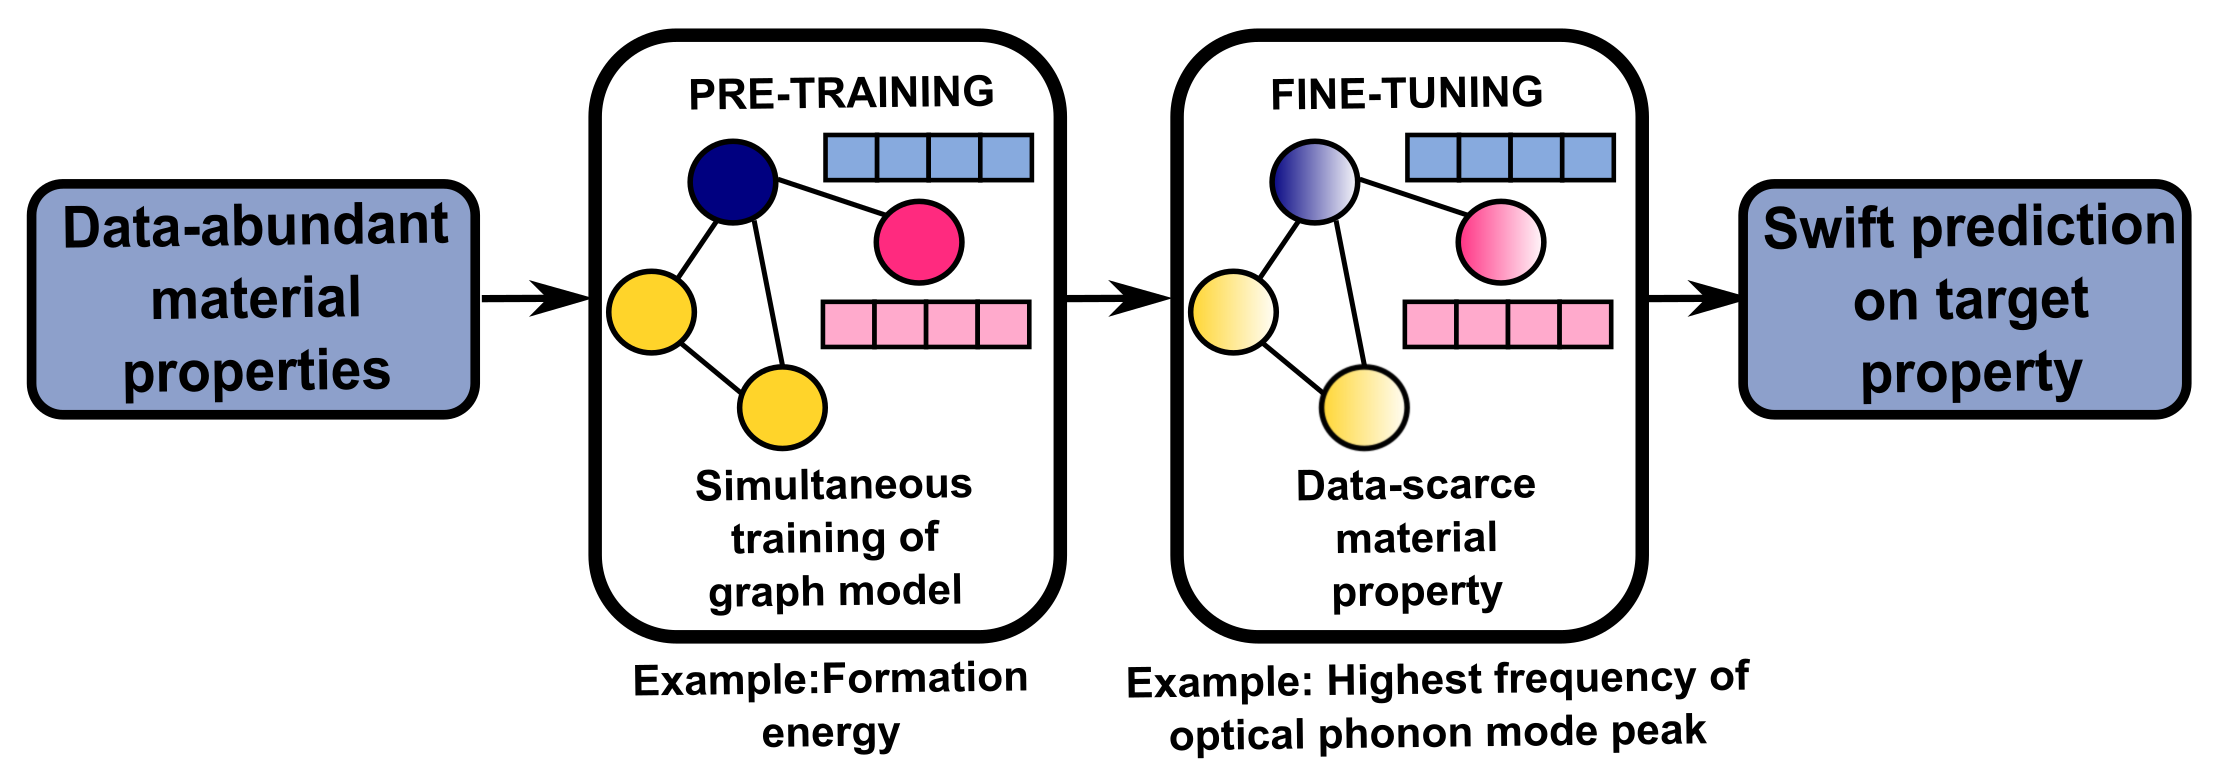

# Installation
Install and initialize condacolab, a library that allows you to use the Conda package manager within a Google Colab environment


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [ ]:
# import condacolab
# condacolab.check()

✨🍰✨ Everything looks OK!


Install ALIGNN  (It might take ~ 6-8 minutes)

In [2]:
%%time
!conda install alignn dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - alignn
    - dgl=2.1.0
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    absl-py-2.1.0              |     pyhd8ed1ab_1         105 KB  conda-forge
    alignn-2024.10.30          |     pyhd8ed1ab_0          76 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_1          18 KB  conda-forge
    ase-3.23.0                 |     pyhd8ed1ab_0         1.8 MB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_3          18 KB  conda-forge
    babel-2.16.0               |     pyhd8ed1ab_1         6.2 MB  conda-forge
    blinker-1.9.0       

In [1]:
import random
import numpy as np
import torch

seed_value = 123

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading and pre-processing the data


It is always better to standardize and normalize the feature and target values before any ML exercise. The following methodology can be used in the same order for any kind of raw data that is available on any materials data repository.

In the following exercise we will take up the formation energy (in eV/atom) and highest optical mode phonon frequency (in $cm^{-1}$) datasets from the MatBench repository.
<details>
<summary>More Details:</summary>

1.   We split the raw data into train and test dataset in the ratio 90:10
2.   We standardize the target values of both train and test set using the StandardScaler class from sklearn (ref: https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html) using only the training data statistics
     
     **z = (x - u) / s**

          z => Standard score
          x => Sample
          u => Mean
          s => Standard deviation
3.   We then normalize the values between -1 and +1

     **x$_{norm}$ = a + (((x - x$_{minimum}$) * (b - a)) / range of x)**
     
          a, b => Customized range to normalize (say -1 to +1)
4.   We choose 200 random points from the training dataset for illustration


**Make sure to use the training data statistics for standardizing and normalizing both the train and the test set**

</details>

## Download the data

In [2]:
!gdown --folder https://drive.google.com/drive/folders/1LupaRopHz5v0yEyoxzn0j2CWbwCZVrr_?usp=sharing
!gdown --folder https://drive.google.com/drive/folders/1PO7eyZHc8WOHsuYUlYB1Cj1OSR-wJrZA?usp=sharing

Retrieving folder contents
Processing file 1iXEihej_LQgTLPqOk66oPV3o01Ze7SBp current_model.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1iXEihej_LQgTLPqOk66oPV3o01Ze7SBp
To: /content/form_energy/current_model.pt
100% 1.17M/1.17M [00:00<00:00, 15.2MB/s]
Download completed
Retrieving folder contents
Processing file 1Zhs94rpJ8bcM7HBXeg2yx7ifi59oG6xH TEST-UNSTD.json
Processing file 1FKTGiwFOsMD8KlHH-OuD-QBYrD0ApUYx TRAIN-UNSTD.json
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Zhs94rpJ8bcM7HBXeg2yx7ifi59oG6xH
To: /content/phonons/TEST-UNSTD.json
100% 76.5k/76.5k [00:00<00:00, 3.23MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FKTGiwFOsMD8KlHH-OuD-QBYrD0ApUYx
To: /content/phonons/TRAIN-UNSTD.json
100% 683k/683k [00:00<00:00, 6.95MB/s]
Download completed


## Load the data


Load the json file containing the data for bandgap prediction.
Notice that each entry is a dictionary with three important details corresponding to the datapoint

1.   a "ID" named as 'jid'
2.   Target value named as 'target'
3.   The structure saved in jarvis "Atoms" format saved as "atoms"



In [3]:
import json
import pandas as pd
import numpy as np

with open('/content/phonons/TRAIN-UNSTD.json', 'r') as f:
    train_data = json.load(f)

with open('/content/phonons/TEST-UNSTD.json', 'r') as f:
    test_data = json.load(f)

df_train = pd.DataFrame.from_dict(train_data)
df_test = pd.DataFrame.from_dict(test_data)

## Standardize and Normalize the data

In [4]:
#**Standardize**
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_arr = scaler.fit_transform(df_train[['target']]).flatten()
test_arr = scaler.transform(df_test[['target']]).flatten()

In [6]:
# explicit function to normalize array
def normalize(train_arr,test_arr, t_min, t_max):

    diff = t_max - t_min
    diff_arr = max(train_arr) - min(train_arr)

    norm_arr_train = []
    for i in train_arr:
        temp = (((i - min(train_arr))*diff)/diff_arr) + t_min
        norm_arr_train.append(temp)

    norm_arr_test = []
    for i in test_arr:
        temp = (((i - min(train_arr))*diff)/diff_arr) + t_min
        norm_arr_test.append(temp)

    return norm_arr_train, norm_arr_test

range_to_normalize = (-1, 1)
norm_train, norm_test = normalize(train_arr,test_arr, range_to_normalize[0],range_to_normalize[1])

## Visualize the data

Visualize the distributions before and after standardization and normalization

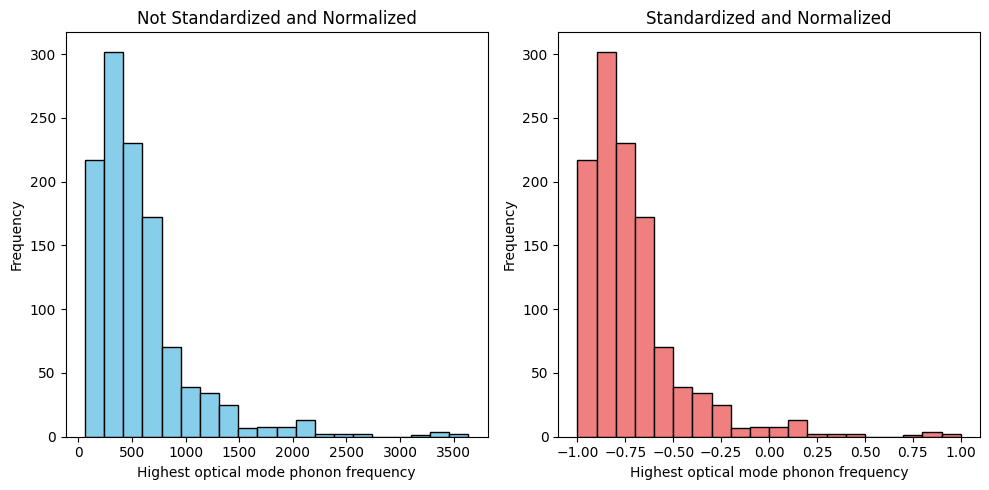

In [7]:
import matplotlib.pyplot as plt
# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # 1 row, 2 columns of subplots.

# Plot the first histogram
axes[0].hist(df_train['target'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Not Standardized and Normalized')
axes[0].set_xlabel('Highest optical mode phonon frequency')
axes[0].set_ylabel('Frequency')

# Plot the second histogram
axes[1].hist(norm_train, bins=20, color='lightcoral', edgecolor='black')
axes[1].set_title('Standardized and Normalized')
axes[1].set_xlabel('Highest optical mode phonon frequency')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [8]:
df_train['target'] = norm_train
df_test['target'] = norm_test

test = df_test.to_dict(orient = 'records')
train = df_train.to_dict(orient = 'records')

## Create dataset for training
We select 200 random datapoints for illustration

In [9]:
import random
def Rand(start, end, num):
  random.seed(123)
  random_ids =  random.sample(range(start, end),num)
  return random_ids
random_pts = Rand(0, 1137, 200)
print(Rand(0, 1137, 200))

train_200 = []
for i in sorted(random_pts, reverse=True):
    train_200.append(train[i])

print(f'No of randomly selected datapoints',len(train_200))

[107, 548, 178, 834, 545, 220, 78, 776, 1098, 680, 697, 106, 326, 276, 690, 683, 502, 335, 3, 893, 179, 773, 143, 13, 646, 918, 208, 89, 189, 291, 258, 43, 597, 881, 976, 543, 961, 75, 624, 703, 1068, 989, 423, 1079, 645, 25, 815, 1050, 889, 1102, 995, 1066, 859, 767, 1044, 65, 371, 169, 997, 536, 348, 685, 1135, 801, 150, 935, 793, 688, 33, 387, 180, 744, 26, 720, 469, 830, 1089, 1026, 122, 589, 1013, 477, 1114, 990, 363, 314, 910, 775, 944, 90, 20, 275, 934, 395, 525, 556, 860, 0, 222, 128, 1045, 727, 181, 887, 17, 1097, 1119, 827, 59, 660, 537, 967, 67, 848, 713, 48, 858, 131, 294, 762, 481, 160, 117, 1062, 1100, 627, 299, 596, 797, 754, 259, 1095, 691, 1059, 244, 341, 791, 885, 127, 278, 931, 42, 715, 921, 923, 622, 878, 57, 324, 665, 1058, 1054, 281, 1024, 214, 1117, 755, 460, 696, 190, 1036, 498, 416, 659, 541, 88, 1025, 164, 403, 1034, 408, 35, 397, 549, 472, 174, 649, 171, 698, 1101, 273, 1094, 277, 991, 1008, 526, 810, 459, 12, 1012, 250, 738, 943, 741, 861, 734, 443, 919, 702

In [10]:
from jarvis.core.atoms import Atoms
import os
output_dir = "./phonons/data"
os.makedirs(output_dir, exist_ok=True) # create data dir if does not exist
output_file_name="id_prop.csv"
with open(output_file_name, 'w') as f:
    for i in train_200:
        atoms = Atoms.from_dict(i["atoms"])
        jid = i["jid"]
        poscar_name = os.path.join(output_dir, "POSCAR-" + str(jid) + ".vasp") # path to poscar
        target = i['target']
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))

# Create a configuration file

Save a configuration file contains all parameters required for defining the model architecture and training process. We will use the alignn_atomwise model for making graph level prediction. Note that alignn_atomwise can make both graph and atom level predictions.

<details>
<summary>More Details:</summary>


``version:`` A string representing the version of the code or data being used. It's useful for tracking changes and reproducibility.

``dataset:`` A string indicating the name of the dataset you're using.

``target:`` The name of the column in your dataset that contains the target property you want to predict.

``atom_features:`` Specifies how the atom features are generated. "cgcnn" typically means using features similar to those used in the CGCNN model.

``neighbor_strategy:`` The method for finding neighboring atoms in the crystal structure. "k-nearest" means considering the 'k' closest atoms as neighbors.

``id_tag:`` A string that represents the ID for each sample in the dataset.

``dtype:`` Specifies the data type used for calculations during the training process. float32 is the standard.

``random_seed:`` An integer that ensures reproducibility by initializing the random number generator with this number.

``classification_threshold:`` If this is a classification problem, it is the threshold above which the results will be labeled as 1.

``n_val, n_test, n_train:`` Specifies the exact number of training, test and validation samples if they are required and different from splitting with train_ratio, val_ratio and test_ratio.

``train_ratio:`` The ratio of data to use for training.

``val_ratio:`` The ratio of data to use for validation.

``test_ratio:`` The ratio of data to use for testing. Note that these three values need to sum to less than or equal to 1.

``target_multiplication_factor:`` A factor to multiply the target property with.

``epochs:`` The number of times the model iterates through the entire training dataset.

``batch_size:`` The number of samples used for one update step of the training.

``weight_decay:`` A regularization technique that adds a small penalty to the model weights during training to prevent overfitting.

``learning_rate:`` The parameter that controls how much the weights are updated during optimization.

``filename:`` The base name for output files (e.g., model checkpoints, predictions).

``warmup_steps:`` The number of steps to linearly increase the learning rate during the initial phase of training.

``criterion:`` The loss function used to calculate the error during training ("mse" is mean squared error).

``optimizer:`` The optimization algorithm used to update the model's weights ("adamw" is a common one).

``scheduler:`` The learning rate scheduler which changes the learning rate as the training progresses.

``pin_memory:`` Whether to load data into pinned memory (faster data loading with GPUs).

``save_dataloader:`` Whether to save the dataloader for restarting a run.

``write_checkpoint:`` Whether to save the model's weights at various points during the training process.

``write_predictions:`` Whether to save the model's predictions on the validation/test sets.

``store_outputs:`` Whether to save the outputs of the model from the validation dataset.

``progress:`` Whether to show a progress bar during training.

``log_tensorboard:`` Whether to log training progress in TensorBoard (a visualization tool).

``standard_scalar_and_pca:`` Whether to apply standard scaling and PCA for pre-processing.

``use_canonize:`` Whether to canonize or permute the structure to a common representation.

``num_workers:`` How many threads to use when loading the data.

``output_dir:`` The directory where all output files are saved.

``use_lmdb:`` Whether to load data from a memory-mapped LMDB database for faster loading.

``normalize_graph_level_loss:`` Whether to normalize graph level losses by the number of atoms or not.

``distributed:`` Whether to use distributed training with multiple GPUs and nodes.

``data_parallel:`` Whether to use data parallelism with multiple GPUs.

``n_early_stopping:`` Number of epochs without improvement in the validation loss before early stopping occurs.

``cutoff:`` Defines the radius cutoff for defining the neighbor lists in angstroms.

``cutoff_extra:`` Extra radius above which a cutoff function can be used if required.

``max_neighbors:`` The maximum number of neighbors to consider for each atom.

``keep_data_order:`` Whether to keep the same order of data in the dataset or randomly shuffle it.

``name:`` Specifies the model to use (alignn_atomwise is a custom model from the previous files).

``alignn_layers:`` The number of ALIGNN layers in the model (the number of alternating crystal and line graph update layers).

``gcn_layers:`` The number of gated graph convolution layers (GCN) to use on the crystal graph.

``atom_input_features:`` The number of features representing each atom in the input.

``edge_input_features:`` The size of the feature vector to use for edge features (bond lengths in our case).

``triplet_input_features:`` The size of the feature vector to use for angle features in the line graph.

``embedding_features:`` The dimension to which the edge and angle features are embedded before the main ALIGNN interaction layers.

``hidden_features:`` The size of the hidden layers within the ALIGNN and GCN layers.

``output_features:`` The number of output features for the graph level prediction.

``grad_multiplier:`` A multiplier applied to gradients. Usually -1 to make gradients become forces based on energy.

``calculate_gradient:`` Whether to calculate gradients (forces) for force prediction.

``atomwise_output_features:`` The number of output features for atom-level predictions.

``graphwise_weight:`` The weight applied to the graph-level loss.

``gradwise_weight:`` The weight applied to the force loss.

``stresswise_weight:`` The weight applied to the stress loss.

``atomwise_weight:`` The weight applied to the per-atom loss.

``link:`` The link function applied to the final output.

``zero_inflated:`` Whether to use zero-inflated loss for sparse data.

``classification:`` Whether this is a classification (not regression) problem.

``force_mult_natoms:`` Multiply the gradient force by the number of atoms.

``energy_mult_natoms:`` Multiply the energy prediction by the number of atoms

``include_pos_deriv:`` Whether to compute derivatives with respect to the positions directly.

``use_cutoff_function:`` Whether to apply a cutoff function to edge interactions based on the bond length.

``inner_cutoff:`` The inner cutoff radius for the cutoff function in angstrom.

``stress_multiplier:`` A multiplier applied to the stress tensor calculation.

``add_reverse_forces:`` Whether to add the reverse force when calculating the total force.

``lg_on_fly:`` If true, the line graph is constructed in the forward function rather than precomputed and saved.

``batch_stress:`` Whether to perform stress calculation as a single batch instead of one by one.

``multiply_cutoff:`` Whether to multiply the edge features with the cutoff function or just use the cutoff for the edge distances.

``use_penalty:`` Whether to add a bondlength penalty to the total loss function.

``extra_features:`` An optional extra feature for each graph.

``exponent:`` The exponent used for calculating the cutoff function.

``penalty_factor:`` The factor by which the bondlength penalty is applied.

``penalty_threshold:`` The bond length below which penalty is applied.

``additional_output_features:`` If we want to predict any other additional output feature in addition to the graph level property, then this should be set to a value greater than zero.

``additional_output_weight:`` This parameter specifies the weight that needs to be applied to the additional_output_features.

</details>



In [11]:
import json
config = {
    "version": "112bbedebdaecf59fb18e11c929080fb2f358246",
    "dataset": "user_data",
    "target": "target",
    "atom_features": "cgcnn",
    "neighbor_strategy": "k-nearest",
    "id_tag": "jid",
    "dtype": "float32",
    "random_seed": 123,
    "classification_threshold": None,
    "n_val": None,
    "n_test": None,
    "n_train": None,
    "train_ratio": 0.8,
    "val_ratio": 0.2,
    "test_ratio": 0,
    "target_multiplication_factor": None,
    "epochs": 30,
    "batch_size": 2,
    "weight_decay": 1e-05,
    "learning_rate": 0.001,
    "filename": "A",
    "warmup_steps": 2000,
    "criterion": "mse",
    "optimizer": "adamw",
    "scheduler": "onecycle",
    "pin_memory": False,
    "save_dataloader": False,
    "write_checkpoint": True,
    "write_predictions": True,
    "store_outputs": True,
    "progress": True,
    "log_tensorboard": False,
    "standard_scalar_and_pca": False,
    "use_canonize": True,
    "num_workers": 0,
    "cutoff": 8.0,
    "cutoff_extra": 3.0,
    "max_neighbors": 12,
    "keep_data_order": True,
    "normalize_graph_level_loss": False,
    "distributed": False,
    "data_parallel": False,
    "n_early_stopping": None,
    "output_dir": "temp",
    "use_lmdb": True,
    "model": {
        "name": "alignn_atomwise",
        "alignn_layers": 4,
        "gcn_layers": 4,
        "atom_input_features": 92,
        "edge_input_features": 80,
        "triplet_input_features": 40,
        "embedding_features": 64,
        "hidden_features": 64,
        "output_features": 1,
        "grad_multiplier": -1,
        "calculate_gradient": False,
        "atomwise_output_features": 0,
        "graphwise_weight": 1.0,
        "gradwise_weight": 1.0,
        "stresswise_weight": 0.0,
        "atomwise_weight": 0.0,
        "link": "identity",
        "zero_inflated": False,
        "classification": False,
        "force_mult_natoms": False,
        "energy_mult_natoms": False,
        "include_pos_deriv": False,
        "use_cutoff_function": False,
        "inner_cutoff": 3.0,
        "stress_multiplier": 1.0,
        "add_reverse_forces": True,
        "lg_on_fly": True,
        "batch_stress": True,
        "multiply_cutoff": False,
        "use_penalty": True,
        "extra_features": 0,
        "exponent": 5,
        "penalty_factor": 0.1,
        "penalty_threshold": 1.0
    }
}

file_path = "config.json"

with open(file_path, "w") as json_file:
    json.dump(config, json_file)

with open("/content/form_energy/config.json", "w") as json_file:
    json.dump(config, json_file)

# Train a model from scratch

We now construct a model from scratch for predicting the highest optical phonon mode frequncy of the materials.
The config.json file contains all the required parameters for load and training the alignn_atomwise model.

Training the SCRATCH model

In [13]:

!train_alignn.py --help

DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
fatal: not a git repository (or any of the parent directories): .git
usage: train_alignn.py [-h] [--root_dir ROOT_DIR] [--config_name CONFIG_NAME]
                       [--file_format FILE_FORMAT]
                       [--classification_threshold CLASSI

In [14]:
%%time
!train_alignn.py --root_dir "./" --config "config.json" --output_dir=phonons --epochs 30

/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
fatal: not a git repository (or any of the parent directories): .git
world_size 1
root_dir ./
id_prop_csv_file exists True
len dataset 200
train_stress False
Using LMDB dataset.
MAX val: 0.400152
MIN val: -0.998882
MAD: 0.17105815215
Data error Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
data range 0.400152 -0.998882
line_graph True
100% 160/160 [00:01<00:00, 82.84it/s]
data range -0.418111 -0.9782
line_graph True
100% 40/40 [00:00<00:00, 87.77it/s]
n_train: 160
n_val  : 40
n_test : 

# Fine-tune a model using a model pre-trained on formation energy dataset

Now we load a pre-trained model on formation energy and then fine-tune it on the phonons dataset.
We will compare the predictions made by the fine-tuned model and the model constructed from scratch for the higest optical phonon mode predictions.
<details>
<summary>More Details:</summary>

Loading a pre-trained model on formation energy and fine-tuning on the phonon dataset. Note the pre-trained model checkpoint was obtained by training on 1000 formation energy datapoints for 500 epochs. The above code for constructing the scratch model with the respective data and `--epochs 500` can be used to generate the checkpoint.

</details>

In [15]:
%%time
!train_alignn.py --root_dir "./" --config "config.json" --output_dir=fine-tune --restart_model_path='/content/form_energy/current_model.pt' --epochs 30

/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
fatal: not a git repository (or any of the parent directories): .git
world_size 1
root_dir ./
id_prop_csv_file exists True
len dataset 200
train_stress False
Restarting the model training: /content/form_energy/current_model.pt
Rest config name='alignn_atomwise' alignn_layers=4 gcn_layers=4 atom_input_features=92 edge_input_features=80 triplet_input_features=40 embedding_features=64 hidden_features=64 output_features=1 grad_multiplier=-1 calculate_gradient=False atomwise_output_features=0 graphwise_weight=1.0 gradwi

# Test the scratch and fine-tuned model

We will now test both the scratch and the fine-tuned model on the prediction accuracy

In [16]:
import sys
from alignn.models.alignn_atomwise import ALIGNNAtomWise, ALIGNNAtomWiseConfig
import torch
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph
import pandas as pd
import numpy as np

filename_scratch = 'phonons/best_model.pt'
filename_ft = 'fine-tune/best_model.pt'
device = "cuda"

# Initialize two separate models
model_scratch = ALIGNNAtomWise(ALIGNNAtomWiseConfig(name ='alignn_atomwise',gcn_layers = 4, atom_input_features = 92, alignn_layers = 4, output_features = 1 ))
model_ft = ALIGNNAtomWise(ALIGNNAtomWiseConfig(name ='alignn_atomwise',gcn_layers = 4, atom_input_features = 92, alignn_layers = 4, output_features = 1 ))

# Load state dicts seperately
state_dict_scratch = torch.load(filename_scratch, map_location=device)
state_dict_ft = torch.load(filename_ft, map_location=device)

# Load the model parameters
model_scratch.load_state_dict(state_dict_scratch)
model_ft.load_state_dict(state_dict_ft)

model_scratch.eval()
model_ft.eval()

model_scratch = model_scratch.to(device)
model_ft = model_ft.to(device)

cutoff = 8.0
max_neighbors = 12

# Save the current standard output (e.g., the console) to a variable
original_stdout = sys.stdout
results_scratch = []
results_ft = []
for i in test:
    # Testing Scratch Model
    atoms = Atoms.from_dict(i["atoms"])
    g, lg = Graph.atom_dgl_multigraph(
        atoms, cutoff=float(cutoff), max_neighbors=max_neighbors)
    out_data_scratch = (model_scratch([g.to(device), lg.to(device),[atoms.lattice.a,atoms.lattice.b,atoms.lattice.c]])['out']
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist())
    results_scratch.append({ "jid": i['jid'],
            "out_data": out_data_scratch[0],
            "target": i['target']
        })
    print("jid", i['jid'],
            "out_data", out_data_scratch[0],
            "target", i['target'])

    # Testing Fine-tuned model
    out_data_ft = (model_ft([g.to(device), lg.to(device),[atoms.lattice.a,atoms.lattice.b,atoms.lattice.c]])['out']
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist())
    results_ft.append({ "jid": i['jid'],
            "out_data": out_data_ft[0],
            "target": i['target']
        })
    print("jid", i['jid'],
            "out_data", out_data_ft[0],
            "target", i['target'])
csv_scratch = pd.DataFrame(results_scratch)
csv_ft = pd.DataFrame(results_ft)

/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


jid 1250 out_data -0.7172368764877319 target -0.6556735606484069
jid 1250 out_data -0.6574678421020508 target -0.6556735606484069
jid 1248 out_data -0.732584536075592 target -0.6852990497484629
jid 1248 out_data -0.6802908778190613 target -0.6852990497484629
jid 1244 out_data -0.7075853943824768 target -0.6679709334823924
jid 1244 out_data -0.6337385177612305 target -0.6679709334823924
jid 1242 out_data -0.8774534463882446 target -0.8870877585243153
jid 1242 out_data -0.8631584048271179 target -0.8870877585243153
jid 1238 out_data -0.5332975387573242 target -0.0044717719396316635
jid 1238 out_data -0.44088518619537354 target -0.0044717719396316635
jid 1230 out_data -0.8544633388519287 target -0.878703186137507
jid 1230 out_data -0.8620232939720154 target -0.878703186137507
jid 1211 out_data -0.9220153093338013 target -0.9206260480715484
jid 1211 out_data -0.8942254185676575 target -0.9206260480715484
jid 1208 out_data -0.7314354181289673 target -0.6785913918390162
jid 1208 out_data -0.

## Undo the standardization and normalization operation

Remember to undo the normalization and standardization operations in the same order as mentioned before analyzing the results. The follwing formulas are used in the same order to undo the operations.
<details>
<summary>More Details:</summary>

**Unnormalized_value =  $\frac{(\textbf{Normalized value} + 1)}{2}$  $\times$ (Original_scaled_max - Original_scaled_min) + Original_scaled_min**

**Original_value = (Unnormalized_value $\times$ Original_std_dev) + Original_mean**

```
      Original_std_dev => standard deviation of unscaled and unnormalized training dataset
      Original_mean => mean of unscaled and unnormalized training dataset
      Original_scaled_max =>  maxima of the scaled training dataset
      Original_scaled_min =>  minima of the scaled training dataset
```
</details>

In [17]:
from sklearn.preprocessing import StandardScaler
import statistics as s
scaler = StandardScaler()
with open('/content/phonons/TRAIN-UNSTD.json', 'r') as f:
    train_data = json.load(f)
df_train = pd.DataFrame.from_dict(train_data)

#Get min and max from this array
arr1 = scaler.fit_transform(df_train[['target']]).flatten()
#Get range from standardized data
original_min = min(arr1)
original_max = max(arr1)


#Get the mean and std_dev from this array
raw_target = np.array(df_train['target'])
# Standardized data mean, stdev and range
original_mean = s.mean(raw_target)
original_std = s.stdev(raw_target)


def undo_normalization_and_standardization(normalized_array, original_mean, original_std, original_min, original_max):
    # Step 1: Undo the normalization
    unnormalized_array = (normalized_array + 1) / 2 * (original_max - original_min) + original_min

    # Step 2: Undo the standardization
    original_array = unnormalized_array * original_std + original_mean

    return original_array

## Analyze the performance metrics

In [18]:
import pandas
from sklearn.metrics import r2_score, mean_absolute_error
###################Print results of the scratch model##################
pred = undo_normalization_and_standardization(np.array(csv_scratch["out_data"]), original_mean, original_std, original_min, original_max)
target = undo_normalization_and_standardization(np.array(csv_scratch["target"]), original_mean, original_std, original_min, original_max)
r2= r2_score(target, pred)
mae = mean_absolute_error(target, pred)
print('Scratch model R2 score',r2)
print('Scratch model MAE score',mae)
print('############################################')
##################Print results of the fine-tuned model################
pred = undo_normalization_and_standardization(np.array(csv_ft["out_data"]), original_mean, original_std, original_min, original_max)
target = undo_normalization_and_standardization(np.array(csv_ft["target"]), original_mean, original_std, original_min, original_max)
r2= r2_score(target, pred)
mae = mean_absolute_error(target, pred)
print('Fine-tuned model R2 score',r2)
print('Fine-tuned model MAE score',mae)


Scratch model R2 score 0.6090605125506325
Scratch model MAE score 185.55676204208555
############################################
Fine-tuned model R2 score 0.691848606114772
Fine-tuned model MAE score 156.4463468936789


# Using other pre-trained models from ALIGNN

We'll now utilize another pre-trained model from the repository. The following code utilizes a model trained on JARVIS-DFT formation energy.

Alter the snippet of code below to compare the formation energies of the structures generated from crystalLLM and Chemeleon
Refer to the [documentation](https://github.com/usnistgov/alignn) for other pre-trained models

<details>
<summary>Solution:</summary>

```python
atoms = Atoms.from_cif('/content/Si.cif')# Load the pickle/cif files that you generated in the previous exercise
atoms.write_poscar('POSCAR_trial')

!pretrained.py --model_name jv_formation_energy_peratom_alignn  --file_format poscar --file_path POSCAR_trial
```

</details>